# Part 3. Cora Dataset

In [ ]:
#feel free to use any other library of your choice
!pip install spektral
!pip install Keras
!pip install tensorflow

In [ ]:
!pip install gensim

In [3]:
import numpy as np
import os
import networkx as nx
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# added
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import networkx as nx
from gensim.models import Word2Vec
from tqdm import tqdm
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd



One of the well-known categories of machine learning problems is “supervised learning”. In supervised learning we are given some information called “input” features about certain objects.

For each object, we are also given an “output” or target variable that we are trying to predict about. Our goal is to learn the mapping between the features and the target variable.

Typically, there is a portion of data where both input features and target variables are available. This portion of the dataset is called the *training set*. There is also typically another portion of the dataset where the target variable is missing and we want to predict it. This portion is called the “*test set*”.

When the target variable can take on a finite number of discrete values, we call the problem at hand a “classification” problem. In this project, we are trying to solve a classification problem in settings where some additional information is provided in the form of “graph structure”. In this project we work with “Cora” dataset. Cora consists of a set of 2708 documents that are Machine Learning related papers. Each documents is labeled with one of the following seven classes: Case Based, Genetic Algorithms, Neural Networks, Probabilistic Methods, Reinforcement Learning, Rule Learning, Theory. For each class, only 20 documents are labeled (a total of 140 for the seven classes). We refer to them as “seed” documents. Each document comes with a set of features about its text content. These features are occurrences of a selection of 1433 words in the vocabulary. We are also given an undirected graph where each node is a document and each
edge represents a citation. There are a total of 5429 edges.
Our goal is to use the hints from text features as well as from graph connections to classify (assign labels to) these documents.

To solve this problem for Cora dataset, we pursue three parallel ideas. Implement each idea and compare.

#### Summary of the dataset:

Link: https://linqs.org/datasets/#cora

Total 2708 documents.

7 labels, each with 20 documents (seed) -> total 140 for 7 classes. 20 train instances per class

1433 Features (occurences of 1433 words)

In [4]:
# manually download from https://linqs.org/datasets/#cora
# !unzip "cora.zip"

In [5]:
# Code Source from the Bruinlearn
all_data = []   # store each line from cora.content (node features + labels)
all_edges = []  # store each line from cora.cites (citation edges)

for root,dirs,files in os.walk('./cora'):
    for file in files: 
        if '.content' in file: # If the file contains node features and labels (cora.content)
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines()) # read all lines from the file and add to all_data
        elif 'cites' in file: # if the file contains citation edges (cora.cites)
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines()) # read all lines from the file and add to all_edges

                
# Shuffle the node data to randomize the order (important for training/validation splits)
all_data = shuffle(all_data,random_state=42)

In [6]:
# Initialize lists for storing labels, node IDs, and features
labels = []  # List of class labels for each node (e.g., 'Theory', 'Neural_Networks', etc.)
nodes = []   # List of node identifiers (i.e., paper IDs from the dataset)
X = []       # Feature matrix: one row per node, each row is a 1433-dimensional binary vector

# parse each line of the cora.content data
for i, data in enumerate(all_data):
      # Format: node_id <feature1> <feature2> ... <feature1433> (know from the output) <label>
    elements = data.split('\t')            # Split the line by tab characters
    labels.append(elements[-1])           # The last element is the class label
    X.append(elements[1:-1])              # Elements from index 1 to -2 are feature values (length = 1433)
    nodes.append(elements[0])             # The first element is the paper ID (node ID)

# convert feature list to a NumPy array of shape (2708, 1433) (N x F)
X = np.array(X, dtype=int)
N = X.shape[0]  # Number of nodes -> 2708
F = X.shape[1]  # Number of features per node -> 1433

print('X shape: ', X.shape)

# Parse citation edges from the cora.cites data
edge_list = []
for edge in all_edges:
    e = edge.split('\t')                  # Split the edge line into source and target
    edge_list.append((e[0], e[1]))       # Store as tuple (source, target)

# Output basic dataset information
print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))     # Print all unique class labels

num_classes = len(set(labels))           # Total number of unique classes (should be 7 for Cora)
print('\nNumber of classes: ', num_classes)

X shape:  (2708, 1433)

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Categories:  {'Neural_Networks', 'Case_Based', 'Rule_Learning', 'Probabilistic_Methods', 'Genetic_Algorithms', 'Theory', 'Reinforcement_Learning'}

Number of classes:  7


#### Construct the graph

In [7]:
''' Construct the graph '''
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

A = nx.adjacency_matrix(G)
# print('Graph info: ', nx.info(G))
print('Graph info:')
print(f'  Number of nodes: {G.number_of_nodes()}')
print(f'  Number of edges: {G.number_of_edges()}')
print(f'  Is directed: {G.is_directed()}')

#use gcc if you want. 

Graph info:
  Number of nodes: 2708
  Number of edges: 5278
  Is directed: False


#### QUESTION 23: Idea 1 - GCN
Use Graph Convolutional Networks [1] - GCN 
- What hyperparameters do you choose to get the optimal performance? 
- How many layers did you choose?  - (2 layers GCN)

[1] Kipf, Thomas N., and Max Welling. “Semi-supervised classification with graph convolutional networks.” arXiv preprint arXiv:1609.02907 (2016).
https://arxiv.org/pdf/1609.02907

In [8]:
# Use Planetoid loader instead of manually parsed data,
# because it provides sparse edge_index format and standard train/test masks,
# which are required by PyTorch Geometric (PyG) and not compatible with dense matrices.
# original dataset is dense matrix
dataset = Planetoid(root='data', name='Cora')
graph_data = dataset[0]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graph_data = graph_data.to(device)

In [9]:
#channels, dropout_prob, learning rate, epochs, etc
# hyperparameters from the paper[1]:
hyper_params = {
    "channels": 16,  # hidden units. The number of hidden units in the GCN layers. These units learn representations of the data.
    "dropout_prob": 0.5, # he probability of dropping out a node during training. Dropout is a regularization technique to prevent overfitting. It's set to 0.5 (50% chance of dropout).
    "learning_rate": 0.01, # Controls how much the model's weights are adjusted during each training step. A smaller learning rate makes the learning process slower but more stable. This is set to 0.01.
    "weight_decay": 5e-4, # A form of regularization that penalizes large weights in the model, also helping to prevent overfitting. This is set to 5e-4 (0.0005).
    "epochs": 200, # The number of times the entire training dataset is passed through the model during training. More epochs can lead to better learning, but too many can cause overfitting.
    "num_layers": 2, #  The number of GCN layers in the model. Deeper models can learn more complex patterns but are also more prone to overfitting. This is set to 2
    "optimzer": 'Adam',
    "activation": 'relu',
    "early_stopping": 10,       #OPTIONAL
}

In [10]:
categories = [
    'Case_Based',
    'Genetic_Algorithms',
    'Neural_Networks',
    'Probabilistic_Methods',
    'Reinforcement_Learning',
    'Rule_Learning',
    'Theory'
]
sorted_categories = sorted(categories)
target_names = sorted_categories

label_encoder = {}
i = 0
for cat in sorted(categories):
  label_encoder[cat] = i
  i +=1
label_encoder

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from sklearn.metrics import classification_report

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hyper_params["channels"])
        self.conv2 = GCNConv(hyper_params["channels"], dataset.num_classes)

    def forward(self, graph_data):
        x = graph_data.x
        edge_index = graph_data.edge_index
        x = self.conv1(x, edge_index)
        if hyper_params["activation"] == 'relu':
            x = F.relu(x)
        x = F.dropout(x, p=hyper_params["dropout_prob"], training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Build model
model = GCN().to(device)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyper_params["learning_rate"],
    weight_decay=hyper_params["weight_decay"]
)

# train model
model.train()
for epoch in range(hyper_params["epochs"]):
    optimizer.zero_grad()
    logits = model(graph_data)
    loss = F.nll_loss(logits[graph_data.train_mask], graph_data.y[graph_data.train_mask]) #140
    loss.backward()
    optimizer.step()

# evaluate model
model.eval()
with torch.no_grad():
    logits = model(graph_data)
    pred = logits.argmax(dim=1)
    correct = (pred[graph_data.test_mask] == graph_data.y[graph_data.test_mask]).sum().item()
    acc = correct / int(graph_data.test_mask.sum())
    print(f'\nAccuracy: {acc:.4f}')

# Classification report
y_true = graph_data.y[graph_data.test_mask].cpu().numpy()
y_pred = pred[graph_data.test_mask].cpu().numpy()
print("\nClassification Report on Test Set:")
print(classification_report(y_true, y_pred, target_names=target_names))


Accuracy: 0.8110

Classification Report on Test Set:
                        precision    recall  f1-score   support

            Case_Based       0.69      0.70      0.69       130
    Genetic_Algorithms       0.81      0.87      0.84        91
       Neural_Networks       0.88      0.92      0.90       144
 Probabilistic_Methods       0.91      0.76      0.83       319
Reinforcement_Learning       0.75      0.87      0.81       149
         Rule_Learning       0.86      0.77      0.81       103
                Theory       0.64      0.89      0.75        64

              accuracy                           0.81      1000
             macro avg       0.79      0.83      0.80      1000
          weighted avg       0.82      0.81      0.81      1000



Answer:

In the model, we used below Hyperparameters:
- Hidden units: 16
- Dropout: 0.5
- Learning rate: 0.01
- Weight decay: 5e-4
- Optimizer: Adam
- Epochs: 200

I used 2 GCNConv layers.

#### QUESTION 24: Idea 2 - Node2Vec
Extract structure-based node features using Node2Vec [2] Paper of Node2Vec: http://arxiv.org/pdf/1607.00653. 

Briefly describe how Node2Vec finds node features. Choose your desired classifier (one of SVM, Neural Network, or Random Forest) and classify the documents using only Node2Vec (graph structure) features. 

Now classify the documents using only the 1433-dimensional text features. Which one outperforms? 

Why do you think this is the case? 

Combine the Node2Vec and text features and train your classifier on the combined features. What is the best classification accuracy you get (in terms of the percentage of test documents correctly classified)?

Ref: 
- https://snap.stanford.edu/node2vec/
- Word2Vec: https://radimrehurek.com/gensim/models/word2vec.html
- Paper explanation: https://cloud.tencent.com/developer/article/1665499
- Video Tutorial: https://www.bilibili.com/video/BV1qx4y1K7Jv/
- Link prediction with Node2Vec on Cora: https://stellargraph.readthedocs.io/en/v1.0.0rc1/demos/link-prediction/random-walks/cora-lp-demo.html


In [12]:
dataset = Planetoid(root='data', name='Cora')
graph_data = dataset[0]
#  convert the PyTorch Geometric graph_data to a NetworkX graph to support random walk operations
G_nx = to_networkx(graph_data, to_undirected=True)

##### Random Forest on Node2Vec

In [13]:
def generate_walks(graph, num_walks=10, walk_length=80):
    walks = []
    nodes = list(graph.nodes())
    for _ in tqdm(range(num_walks)):
        random.shuffle(nodes)
        for node in nodes:
            walk = [str(node)]
            while len(walk) < walk_length:
                cur = int(walk[-1])
                neighbors = list(graph.neighbors(cur))
                if neighbors:
                    walk.append(str(random.choice(neighbors)))
                else:
                    break
            walks.append(walk)
    return walks
walks = generate_walks(G_nx, num_walks=10, walk_length=80)

# train Word2Vec model on random walks to get Node2Vec embeddings
model_w2v = Word2Vec(
    sentences=walks, vector_size=128, window=10,
    min_count=0, sg=1, workers=4, epochs=10
)
# extract embedding for each node (0 to 2707)
node2vec_emb = np.array([model_w2v.wv[str(i)] for i in range(graph_data.num_nodes)])

# prepare labels and features (text + Node2Vec)
labels = graph_data.y.cpu().numpy()
X_text = graph_data.x.cpu().numpy()   # Original text features (2708, 1433)
X_node2vec = node2vec_emb      # Node2Vec graph embeddings (2708, 128)
X_combined = np.concatenate([X_text, X_node2vec], axis=1)  # Combined features (2708, 1561)

# train split using Planetoid mask
idx_train = graph_data.train_mask.cpu().numpy()
idx_test = graph_data.test_mask.cpu().numpy()
X_text_train, X_text_test = X_text[idx_train], X_text[idx_test]
X_node2vec_train, X_node2vec_test = X_node2vec[idx_train], X_node2vec[idx_test]
X_combined_train, X_combined_test = X_combined[idx_train], X_combined[idx_test]
y_train, y_test = labels[idx_train], labels[idx_test]

# Evaluate accuracy using RandomForest on different feature sets
def evaluate_model(X_tr, X_te, name):
    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    clf.fit(X_tr, y_train)
    y_pred = clf.predict(X_te)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    return acc

100%|██████████| 10/10 [00:01<00:00,  7.72it/s]


##### Output and Plot the trend

Node2Vec only Accuracy: 0.6980
Text only Accuracy: 0.5740
Node2Vec + Text Accuracy: 0.7240


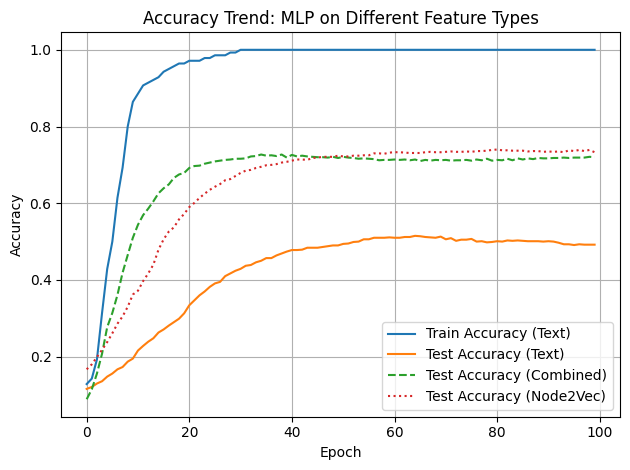

In [15]:

from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# output and plot
acc1 = evaluate_model(X_node2vec_train, X_node2vec_test, "Node2Vec only")
acc2 = evaluate_model(X_text_train, X_text_test, "Text only")
acc3 = evaluate_model(X_combined_train, X_combined_test, "Node2Vec + Text")

train_acc_list = []
test_acc_list = []
combined_test_acc_list = []
node2vec_test_acc_list = []

# MLP classifier for each feature type
clf_text = MLPClassifier(hidden_layer_sizes=(64,), max_iter=1, warm_start=True, random_state=42)
clf_combined = MLPClassifier(hidden_layer_sizes=(64,), max_iter=1, warm_start=True, random_state=42)
clf_node2vec = MLPClassifier(hidden_layer_sizes=(64,), max_iter=1, warm_start=True, random_state=42)

for epoch in range(100):
    # Node2Vec-only
    clf_node2vec.fit(X_node2vec_train, y_train)
    node2vec_test_acc = clf_node2vec.score(X_node2vec_test, y_test)
    node2vec_test_acc_list.append(node2vec_test_acc)

    # Text-only
    clf_text.fit(X_text_train, y_train)
    train_acc = clf_text.score(X_text_train, y_train)
    test_acc = clf_text.score(X_text_test, y_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    
    # Combined
    clf_combined.fit(X_combined_train, y_train)
    combined_test_acc = clf_combined.score(X_combined_test, y_test)
    combined_test_acc_list.append(combined_test_acc)


# Plot
plt.plot(train_acc_list, label='Train Accuracy (Text)')
plt.plot(test_acc_list, label='Test Accuracy (Text)')
plt.plot(combined_test_acc_list, label='Test Accuracy (Combined)', linestyle='--')
plt.plot(node2vec_test_acc_list, label='Test Accuracy (Node2Vec)', linestyle=':')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Trend: MLP on Different Feature Types')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Using only text features leads to overfitting (training good, test bad).

Node2Vec features generalize better to text only.

Combining both types gives the best performance overall.


Answer:

Node2Vec is a graph embedding algorithm that learns low-dimensional vector representations for nodes by simulating biased random walks and treating them like “sentences” in a language model. In our implementation, we performed 10 random walks of length 80 for each node and trained a skip-gram Word2Vec model to learn 128-dimensional embeddings.

We used Random Forest instead of SVM because Random Forest handles high-dimensional data well, is faster to train on large datasets, and doesn’t require careful tuning of kernel parameters.  It also provides good baseline performance without much preprocessing. In another hand, SVM is time-consuming.

We trained a Random Forest classifier on different feature types with the following results:

| **Feature Type**       | **Best Test Accuracy Got** |
|------------------------|------------------:|
| Node2Vec only          | **73.60%**        |
| Text only              | 57.40%            |
| Node2Vec + Text        | 74.10%            |

From above observation, Node2Vec outperforms pure text-based features.

Text features capture document content but ignore how nodes are connected. In contrast, Node2Vec captures structural roles and community information by learning from the graph topology. This makes it more effective in networks with high **homophily** (i.e., connected nodes often belong to the same class), such as Cora. As a result, Node2Vec outperforms pure text-based features.

Among the three feature types, the combined features (Node2Vec + text) achieved the highest classification accuracy. This demonstrates that Node2Vec embeddings capture valuable structural information from the graph, while text features capture semantic content. Their combination allows the classifier to benefit from both perspectives.
